# Quick Start

In [1]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

In [2]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" I am"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" happy!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" sad!"}

In [3]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    
    # 通常我们会根据状态决定下一个节点
    user_input = state['graph_state'] 
    
    # 这里我们在节点2和节点3之间简单实现 50/50 的概率分配
    if random.random() < 0.5:

        # 50% 时间， 我们返回节点2
        return "node_2"
    
    # 50% 时间， 我们返回节点3
    return "node_3"

In [4]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# 构建图表
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 连接逻辑
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# 编译
graph = builder.compile()

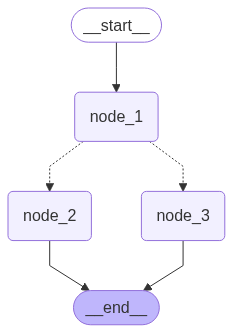

In [5]:
# 可视化
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
graph.invoke({"graph_state" : "Hi, this is Lance."})

---Node 1---
---Node 3---


{'graph_state': 'Hi, this is Lance. I am sad!'}

In [10]:
%pip install langgraph langchain_openai

Looking in indexes: https://mirrors.ustc.edu.cn/pypi/simple, https://pypi.org/simple
  Using cached tiktoken-0.9.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached regex-2024.11.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.3/753.3 kB 6.1 MB/s eta 0:00:00
Using cached distro-1.9.0-py3-none-any.whl (20 kB)
Using cached tiktoken-0.9.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
Using cached regex-2024.11.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (792 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [langchain_openai][openai]
Note: you may need to restart the kernel to use updated packages.


# Email Classification Agent

In [1]:
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage
from transformers import pipeline
import torch
from langchain_openai import ChatOpenAI
from IPython.display import Image, display

2025-06-30 09:02:26,639 - opentelemetry.sdk._shared_internal - ERROR - Exception while exporting Span.
Traceback (most recent call last):
  File "/home/rhs/miniconda3/envs/reinforcement_learning/lib/python3.11/site-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/rhs/miniconda3/envs/reinforcement_learning/lib/python3.11/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/rhs/miniconda3/envs/reinforcement_learning/lib/python3.11/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/rhs/miniconda3/envs/reinforcement_learning/lib/python3.11/site-packages/urllib3/connectionpool.py", line 787, in urlopen
    response = self._make_

In [16]:
class EmailState(TypedDict):
    # 正在处理的电子邮件
    email: Dict[str, Any]  # 包含主题、发件人、正文等。
    
    # 分析与决策
    is_spam: Optional[bool]
    
    # 响应生成
    draft_response: Optional[str]
    
    # 处理元数据
    messages: List[Dict[str, Any]]  # 跟踪与 LLM 的对话以进行分析

    spam_reason: Optional[str]  # 如果是垃圾邮件，记录原因

    email_category: Optional[str]  # 分类结果，例如 "工作"、"个人"、"促销" 等

In [3]:
def _initializeDeepSeekModel():
    """初始化 DeepSeek V3 API 模型"""
    try:
        # 设置 DeepSeek API
        model = ChatOpenAI(
            api_key='sk-e5965c4427e647e080f38e4fc50d95e0',  # 在环境变量中设置您的 API Key
            base_url="https://api.deepseek.com",
            model="deepseek-chat",  # 或 "deepseek-coder"
            temperature=0.1,
            max_tokens=512,
        )
        
        return model
        
    except Exception as e:
        print(f"DeepSeek API 模型初始化失败: {str(e)}")
        return None
    
# Initialize our LLM
model = _initializeDeepSeekModel()

In [ ]:
def read_email(state: EmailState):
    """Alfred reads and logs the incoming email"""
    email = state["email"]
    
    # 在这里我们可能会做一些初步的预处理
    print(f"Alfred is processing an email from {email['sender']} with subject: {email['subject']}")
    
    # 这里不需要更改状态
    return {}

def classify_email(state: EmailState):
    """Alfred uses an LLM to determine if the email is spam or legitimate"""
    email = state["email"]
    
    # 为 LLM 准备提示
    prompt = f"""
    As Alfred the butler, analyze this email and determine if it is spam or legitimate.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    First, determine if this email is spam. 
    If it is spam, explain why. you should provide a reason for the spam classification with "reason: <reason here>".
    If it is legitimate, categorize it (inquiry, complaint, thank you, etc.).
    """
    
    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)
    
    # 解析响应的简单逻辑（在实际应用中，您需要更强大的解析）
    response_text = response.content.lower()
    is_spam = "spam" in response_text and "not spam" not in response_text
    
    # 如果是垃圾邮件，请提取原因
    spam_reason = None
    if is_spam and "reason:" in response_text:
        spam_reason = response_text.split("reason:")[1].strip()
    
    # 确定类别是否合法
    email_category = None
    if not is_spam:
        categories = ["inquiry", "complaint", "thank you", "request", "information"]
        for category in categories:
            if category in response_text:
                email_category = category
                break
    
    # 更新消息以进行追踪
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]
    
    # 返回状态更新
    return {
        "is_spam": is_spam,
        "spam_reason": spam_reason,
        "email_category": email_category,
        "messages": new_messages
    }

def handle_spam(state: EmailState):
    """Alfred discards spam email with a note"""
    print(f"Alfred has marked the email as spam. Reason: {state['spam_reason']}")
    print(f"The {state['email_category']} email has been moved to the spam folder.")
    
    # 我们已处理完这封电子邮件
    return {}

def draft_response(state: EmailState):
    """Alfred drafts a preliminary response for legitimate emails"""
    email = state["email"]
    category = state["email_category"] or "general"
    
    # 为 LLM 准备提示词
    prompt = f"""
    As Alfred the butler, draft a polite preliminary response to this email.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    This email has been categorized as: {category}
    
    Draft a brief, professional response that Mr. Hugg can review and personalize before sending.
    """
    
    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)
    
    # 更新消息以进行追踪
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]
    
    # 返回状态更新
    return {
        "draft_response": response.content,
        "messages": new_messages
    }

def notify_mr_hugg(state: EmailState):
    """Alfred notifies Mr. Hugg about the email and presents the draft response"""
    email = state["email"]
    
    print("\n" + "="*50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print(f"Category: {state['email_category']}")
    print("\nI've prepared a draft response for your review:")
    print("-"*50)
    print(state["draft_response"])
    print("="*50 + "\n")
    
    # 我们已处理完这封电子邮件
    return {}

In [34]:
def route_email(state: EmailState) -> str:
    """Determine the next step based on spam classification"""
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"

In [35]:
# 创建 graph
email_graph = StateGraph(EmailState)

# 添加 nodes
email_graph.add_node("read_email", read_email)
email_graph.add_node("classify_email", classify_email)
email_graph.add_node("handle_spam", handle_spam)
email_graph.add_node("draft_response", draft_response)
email_graph.add_node("notify_mr_hugg", notify_mr_hugg)

# 关键：添加入口点 - 从 START 到第一个节点
email_graph.add_edge(START, "read_email")

# 添加 edges - 定义流程
email_graph.add_edge("read_email", "classify_email")

# 从 classify_email 添加条件分支
email_graph.add_conditional_edges(
    "classify_email",
    route_email,
    {
        "spam": "handle_spam",
        "legitimate": "draft_response"
    }
)

# 添加最后的 edges
email_graph.add_edge("handle_spam", END)
email_graph.add_edge("draft_response", "notify_mr_hugg")
email_graph.add_edge("notify_mr_hugg", END)

# 编译 graph
compiled_graph = email_graph.compile()

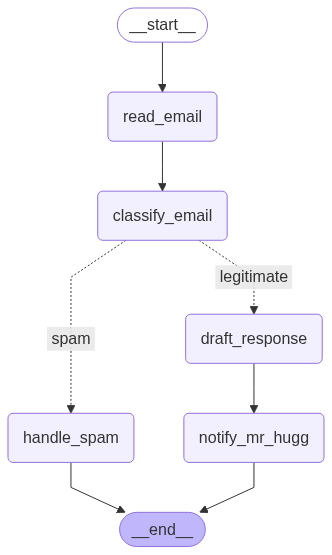

In [36]:
display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [8]:
import os
 
# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-163d02cf-07b1-4c50-9f5c-ed0be86bb47e" 
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-335f4856-c261-4ae8-81a4-5cc2651a858a"
os.environ["LANGFUSE_HOST"] = "https://cloud.langfuse.com" # 🇪🇺 EU region
os.environ["LANGFUSE_DEBUG"] = "True" 
# os.environ["LANGFUSE_HOST"] = "https://us.cloud.langfuse.com" # 🇺🇸 US region

In [37]:
# 合法电子邮件示例
legitimate_email = {
    "sender": "john.smith@example.com",
    "subject": "Question about your services",
    "body": "Dear Mr. Hugg, I was referred to you by a colleague and I'm interested in learning more about your consulting services. Could we schedule a call next week? Best regards, John Smith"
}

# 垃圾邮件示例
spam_email = {
    "sender": "winner@lottery-intl.com",
    "subject": "YOU HAVE WON $5,000,000!!!",
    "body": "CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100."
}

# 处理合法电子邮件
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "draft_response": None,
    "messages": []
})

# 处理垃圾邮件
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke({
    "email": spam_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "draft_response": None,
    "messages": []
})


Processing legitimate email...
Alfred is processing an email from john.smith@example.com with subject: Question about your services
Alfred has marked the email as spam. Reason: None
The $None email has been moved to the spam folder.

Processing spam email...
Alfred is processing an email from winner@lottery-intl.com with subject: YOU HAVE WON $5,000,000!!!
Alfred has marked the email as spam. Reason: **  
1. **suspicious sender address:** the domain "lottery-intl.com" is not a recognized or legitimate lottery organization.  
2. **unsolicited prize claim:** legitimate lotteries do not notify winners via unsolicited emails, especially for large sums of money.  
3. **request for payment:** a genuine lottery would not require a "processing fee" to claim a prize. this is a common scam tactic.  
4. **urgency & poor grammar:** the use of excessive capitalization ("congratulations!") and the demand for immediate action (sending bank details) are red flags.  

**conclusion:** this is a phishin

In [38]:
from langfuse.langchain  import CallbackHandler

# 为 LangGraph/Langchain 初始化 Langfuse CallbackHandler（跟踪）
langfuse_handler = CallbackHandler()

# 处理合法电子邮件
legitimate_result = compiled_graph.invoke(
    input={"email": legitimate_email, "is_spam": None, "spam_reason": None, "email_category": None, "draft_response": None, "messages": []},
    config={"callbacks": [langfuse_handler]}
)

2025-06-30 09:02:25,985 - langfuse - DEBUG - Thread: Media upload consumer thread #0 started and actively processing queue items
2025-06-30 09:02:25,986 - langfuse - DEBUG - Prompt cache initialized.
2025-06-30 09:02:25,991 - langfuse - DEBUG - Startup: Score ingestion consumer thread #0 started with batch size 15 and interval 1s
2025-06-30 09:02:25,993 - langfuse - INFO - Startup: Langfuse tracer successfully initialized | public_key=pk-lf-163d02cf-07b1-4c50-9f5c-ed0be86bb47e | host=https://cloud.langfuse.com | environment=default | sample_rate=1.0 | media_threads=1
2025-06-30 09:02:25,996 - langfuse - DEBUG - Event: on_chain_start, run_id: 99737, parent_run_id: None
2025-06-30 09:02:25,998 - langfuse - DEBUG - Event: on_chain_start, run_id: 1a77a, parent_run_id: 99737
2025-06-30 09:02:26,000 - langfuse - DEBUG - Event: on_chain_end, run_id: 1a77a, parent_run_id: 99737
2025-06-30 09:02:26,001 - langfuse - DEBUG - Trace: Processing span name='read_email' | Full details:
{
  "name": "re

Alfred is processing an email from john.smith@example.com with subject: Question about your services


2025-06-30 09:02:26,989 - langfuse - DEBUG - Queue: Media upload queue is empty, waiting for new jobs
2025-06-30 09:02:27,991 - langfuse - DEBUG - Queue: Media upload queue is empty, waiting for new jobs
2025-06-30 09:02:28,993 - langfuse - DEBUG - Queue: Media upload queue is empty, waiting for new jobs
2025-06-30 09:02:29,996 - langfuse - DEBUG - Queue: Media upload queue is empty, waiting for new jobs
2025-06-30 09:02:30,998 - langfuse - DEBUG - Queue: Media upload queue is empty, waiting for new jobs
2025-06-30 09:02:32,001 - langfuse - DEBUG - Queue: Media upload queue is empty, waiting for new jobs
2025-06-30 09:02:33,003 - langfuse - DEBUG - Queue: Media upload queue is empty, waiting for new jobs
2025-06-30 09:02:34,005 - langfuse - DEBUG - Queue: Media upload queue is empty, waiting for new jobs
2025-06-30 09:02:34,993 - langfuse - DEBUG - Event: on_llm_end, run_id: 4c152, parent_run_id: 26ede
2025-06-30 09:02:34,996 - langfuse - DEBUG - Trace: Processing span name='ChatOpenAI

Alfred has marked the email as spam. Reason: None
The $None email has been moved to the spam folder.


2025-06-30 09:02:36,012 - langfuse - DEBUG - Queue: Media upload queue is empty, waiting for new jobs
2025-06-30 09:02:37,013 - langfuse - DEBUG - Queue: Media upload queue is empty, waiting for new jobs
2025-06-30 09:02:38,015 - langfuse - DEBUG - Queue: Media upload queue is empty, waiting for new jobs
2025-06-30 09:02:39,017 - langfuse - DEBUG - Queue: Media upload queue is empty, waiting for new jobs
2025-06-30 09:02:40,018 - langfuse - DEBUG - Queue: Media upload queue is empty, waiting for new jobs
2025-06-30 09:02:41,021 - langfuse - DEBUG - Queue: Media upload queue is empty, waiting for new jobs
2025-06-30 09:02:42,023 - langfuse - DEBUG - Queue: Media upload queue is empty, waiting for new jobs
2025-06-30 09:02:43,024 - langfuse - DEBUG - Queue: Media upload queue is empty, waiting for new jobs
2025-06-30 09:02:44,026 - langfuse - DEBUG - Queue: Media upload queue is empty, waiting for new jobs
2025-06-30 09:02:45,029 - langfuse - DEBUG - Queue: Media upload queue is empty, w

In [2]:
import base64
from typing import List, TypedDict, Annotated, Optional
from langchain.schema import HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, SystemMessage
from langgraph.graph.message import add_messages
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

from langchain_huggingface import HuggingFacePipeline
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch
import base64
import os
from PIL import Image
from langchain_core.messages import HumanMessage
from pathlib import Path

In [3]:
class AgentState(TypedDict):
    # 提供的文件
    input_file: Optional[str]  # Contains file path (PDF/PNG)
    messages: Annotated[list[AnyMessage], add_messages]

In [4]:
# 本地模型路径配置
LOCAL_MODEL_BASE_PATH = "/home/rhs/code_workspace/hf_models"  # 您的本地模型存储目录
MODEL_NAME = "Qwen/Qwen2.5-VL-32B-Instruct"
LOCAL_MODEL_PATH = os.path.join(LOCAL_MODEL_BASE_PATH, "Qwen2.5-VL-32B-Instruct")

# 常量定义
MAX_TOKENS = 2048
TEMPERATURE = 0.1

def checkLocalModelExists(modelPath: str) -> bool:
    """检查本地模型是否存在"""
    try:
        requiredFiles = [
            "config.json",
            "tokenizer.json", 
            "tokenizer_config.json",
            "generation_config.json"
        ]
        
        modelPathObj = Path(modelPath)
        if not modelPathObj.exists():
            return False
            
        # 检查关键文件是否存在
        for fileName in requiredFiles:
            if not (modelPathObj / fileName).exists():
                print(f"⚠️  缺少文件: {fileName}")
                return False
                
        # 检查是否有模型权重文件
        hasWeights = any([
            list(modelPathObj.glob("*.safetensors")),
            list(modelPathObj.glob("*.bin")),
            list(modelPathObj.glob("pytorch_model*.bin"))
        ])
        
        if not hasWeights:
            print("⚠️  未找到模型权重文件")
            return False
            
        return True
        
    except Exception as e:
        print(f"❌ 检查本地模型时出错: {str(e)}")
        return False

def downloadModelToLocal(modelName: str, localPath: str):
    """下载模型到本地目录"""
    try:
        print(f"🔄 正在下载模型 {modelName} 到本地...")
        
        # 确保本地目录存在
        os.makedirs(localPath, exist_ok=True)
        
        # 下载模型和分词器
        model = Qwen2VLForConditionalGeneration.from_pretrained(
            modelName,
            cache_dir=localPath,
            trust_remote_code=True
        )
        
        processor = AutoProcessor.from_pretrained(
            modelName,
            cache_dir=localPath,
            trust_remote_code=True
        )
        
        tokenizer = AutoTokenizer.from_pretrained(
            modelName,
            cache_dir=localPath,
            trust_remote_code=True
        )
        
        # 保存到指定目录
        model.save_pretrained(localPath)
        processor.save_pretrained(localPath)
        tokenizer.save_pretrained(localPath)
        
        print(f"✅ 模型已成功下载到: {localPath}")
        return True
        
    except Exception as e:
        errorMsg = f"模型下载失败: {str(e)}"
        print(f"❌ {errorMsg}")
        return False

class QwenVisionModel:
    """Qwen 视觉模型封装类"""
    
    def __init__(self, useLocalModel: bool = True):
        self._model = None
        self._processor = None
        self._tokenizer = None
        self._isInitialized = False
        self._useLocalModel = useLocalModel
        self._modelPath = LOCAL_MODEL_PATH if useLocalModel else MODEL_NAME
    
    def _initializeModel(self):
        """初始化 Qwen 视觉模型"""
        try:
            print("🔄 正在初始化 Qwen2.5-VL-32B-Instruct 模型...")
            
            # 检查是否使用本地模型
            if self._useLocalModel:
                if checkLocalModelExists(LOCAL_MODEL_PATH):
                    print(f"✅ 发现本地模型: {LOCAL_MODEL_PATH}")
                    modelPath = LOCAL_MODEL_PATH
                else:
                    print("⚠️  本地模型不存在，尝试下载...")
                    if downloadModelToLocal(MODEL_NAME, LOCAL_MODEL_PATH):
                        modelPath = LOCAL_MODEL_PATH
                    else:
                        print("❌ 本地模型下载失败，使用在线模型")
                        modelPath = MODEL_NAME
                        self._useLocalModel = False
            else:
                modelPath = MODEL_NAME
            
            print(f"📍 使用模型路径: {modelPath}")
            
            # 加载模型和处理器
            loadKwargs = {
                "torch_dtype": torch.bfloat16,
                "attn_implementation": "flash_attention_2", 
                "device_map": "auto",
                "trust_remote_code": True,
                "load_in_4bit": True,  # 启用4位量化以节省内存
            }
            
            # 如果是本地模型，添加本地模式参数
            if self._useLocalModel:
                loadKwargs["local_files_only"] = True
            
            self._model = Qwen2VLForConditionalGeneration.from_pretrained(
                modelPath,
                **loadKwargs
            )
            
            self._processor = AutoProcessor.from_pretrained(
                modelPath,
                trust_remote_code=True,
                local_files_only=self._useLocalModel
            )
            
            self._tokenizer = AutoTokenizer.from_pretrained(
                modelPath,
                trust_remote_code=True,
                local_files_only=self._useLocalModel
            )
            
            self._isInitialized = True
            modelType = "本地" if self._useLocalModel else "在线"
            print(f"✅ Qwen2.5-VL-32B 模型初始化成功 ({modelType})")
            
        except Exception as e:
            errorMsg = f"Qwen 模型初始化失败: {str(e)}"
            print(f"❌ {errorMsg}")
            raise Exception(errorMsg)
    
    # ...existing code...
    def processImageWithText(self, imagePath: str, textPrompt: str) -> str:
        """
        处理图像和文本输入
        
        Args:
            imagePath: 图像文件路径
            textPrompt: 文本提示
            
        Returns:
            模型生成的响应文本
        """
        try:
            if not self._isInitialized:
                self._initializeModel()
            
            # 检查文件是否存在
            if not os.path.exists(imagePath):
                raise FileNotFoundError(f"图像文件不存在: {imagePath}")
            
            # ...existing code... (保留原有的图像处理逻辑)
            # 加载图像
            image = Image.open(imagePath)
            
            # 准备消息格式
            messages = [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "image",
                            "image": image,
                        },
                        {"type": "text", "text": textPrompt},
                    ],
                }
            ]
            
            # 应用聊天模板
            text = self._processor.apply_chat_template(
                messages, 
                tokenize=False, 
                add_generation_prompt=True
            )
            
            # 处理图像和文本
            imageInputs, videoInputs = process_vision_info(messages)
            inputs = self._processor(
                text=[text],
                images=imageInputs,
                videos=videoInputs,
                padding=True,
                return_tensors="pt",
            )
            
            # 移动到设备
            device = "cuda" if torch.cuda.is_available() else "cpu"
            inputs = inputs.to(device)
            
            # 生成响应
            with torch.no_grad():  # 节省内存
                generatedIds = self._model.generate(
                    **inputs,
                    max_new_tokens=MAX_TOKENS,
                    temperature=TEMPERATURE,
                    do_sample=True,
                    pad_token_id=self._tokenizer.eos_token_id
                )
            
            generatedIds = [
                outputIds[len(inputIds):] 
                for inputIds, outputIds in zip(inputs.input_ids, generatedIds)
            ]
            
            responseText = self._processor.batch_decode(
                generatedIds, 
                skip_special_tokens=True, 
                clean_up_tokenization_spaces=False
            )[0]
            
            return responseText.strip()
            
        except Exception as e:
            errorMsg = f"图像处理过程中发生错误: {str(e)}"
            print(f"❌ {errorMsg}")
            return ""

# 初始化全局视觉模型实例（优先使用本地模型）
_qwenVisionModel = QwenVisionModel(useLocalModel=True)

def _initializeQwenTextModel(useLocalModel: bool = True):
    """初始化 Qwen 文本模型用于工具绑定"""
    try:
        print("🔄 正在初始化 Qwen 文本模型...")
        
        # 确定模型路径
        if useLocalModel and checkLocalModelExists(LOCAL_MODEL_PATH):
            modelPath = LOCAL_MODEL_PATH
            print(f"✅ 使用本地模型: {modelPath}")
        else:
            modelPath = MODEL_NAME
            print(f"🌐 使用在线模型: {modelPath}")
        
        # 为了与 LangChain 工具系统兼容，创建文本生成管道
        from transformers import pipeline
        
        pipelineKwargs = {
            "model": modelPath,
            "tokenizer": modelPath,
            "torch_dtype": torch.bfloat16,
            "device_map": "auto",
            "max_new_tokens": MAX_TOKENS,
            "temperature": TEMPERATURE,
            "do_sample": True,
            "trust_remote_code": True,
            "load_in_4bit": True,  # 启用量化
        }
        
        # 如果使用本地模型，添加本地模式参数
        if useLocalModel and checkLocalModelExists(LOCAL_MODEL_PATH):
            pipelineKwargs["local_files_only"] = True
        
        textPipeline = pipeline(
            "text-generation",
            **pipelineKwargs
        )
        
        # 包装为 LangChain 模型
        llm = HuggingFacePipeline(pipeline=textPipeline)
        print("✅ Qwen 文本模型初始化成功")
        return llm
        
    except Exception as e:
        errorMsg = f"Qwen 文本模型初始化失败: {str(e)}"
        print(f"❌ {errorMsg}")
        return None

# ...existing code... (保留其他函数)

def checkSystemRequirements():
    """检查系统要求和依赖"""
    try:
        requirements = []
        
        # 检查本地模型目录
        print(f"📂 本地模型目录: {LOCAL_MODEL_BASE_PATH}")
        if not os.path.exists(LOCAL_MODEL_BASE_PATH):
            print(f"⚠️  本地模型目录不存在，将创建: {LOCAL_MODEL_BASE_PATH}")
            os.makedirs(LOCAL_MODEL_BASE_PATH, exist_ok=True)
        
        # 检查特定模型
        if checkLocalModelExists(LOCAL_MODEL_PATH):
            print(f"✅ 本地模型已存在: {LOCAL_MODEL_PATH}")
        else:
            print(f"⚠️  本地模型不存在: {LOCAL_MODEL_PATH}")
            print("   首次运行时将自动下载")
        
        # ...existing code... (保留原有的系统检查逻辑)
        # 检查 GPU 内存
        if torch.cuda.is_available():
            gpuMemory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
            print(f"📊 GPU 内存: {gpuMemory:.1f} GB")
            
            if gpuMemory < 20:
                requirements.append("⚠️  Qwen2.5-VL-32B 建议至少 20GB GPU 内存（启用量化后）")
            else:
                print("✅ GPU 内存充足")
        else:
            requirements.append("⚠️  未检测到 CUDA，模型将在 CPU 上运行（速度较慢）")
        
        return len(requirements) == 0
        
    except Exception as e:
        errorMsg = f"系统检查时发生错误: {str(e)}"
        print(f"❌ {errorMsg}")
        return False

def _initializeSystemWithTools():
    """初始化完整的工具系统"""
    try:
        print("🚀 开始初始化 Alfred 的工具系统...")
        
        # 初始化文本模型（优先使用本地模型）
        llm = _initializeQwenTextModel(useLocalModel=True)
        
        if llm is None:
            print("❌ 主模型未初始化，无法绑定工具")
            return None, None
        
        # 绑定工具
        llmWithTools = llm.bind_tools(tools, parallel_tool_calls=False)
        print("✅ 模型工具绑定成功")
        
        return llm, llmWithTools
        
    except Exception as e:
        errorMsg = f"工具系统初始化失败: {str(e)}"
        print(f"❌ {errorMsg}")
        return None, None
def checkSystemRequirements():
    """检查系统要求和依赖"""
    try:
        requirements = []
        
        # 检查 GPU 内存
        if torch.cuda.is_available():
            gpuMemory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
            print(f"📊 GPU 内存: {gpuMemory:.1f} GB")
            
            if gpuMemory < 20:
                requirements.append("⚠️  Qwen2.5-VL-32B 建议至少 20GB GPU 内存（启用量化后）")
            else:
                print("✅ GPU 内存充足")
        else:
            requirements.append("⚠️  未检测到 CUDA，模型将在 CPU 上运行（速度较慢）")
        
        # 检查必需的依赖包
        requiredPackages = [
            ("transformers", "transformers"),
            ("torch", "torch"), 
            ("qwen_vl_utils", "qwen-vl-utils"),
            ("PIL", "pillow"),
            ("bitsandbytes", "bitsandbytes")  # 用于量化
        ]
        
        for importName, packageName in requiredPackages:
            try:
                __import__(importName)
                print(f"✅ {packageName} 已安装")
            except ImportError:
                requirements.append(f"❌ 缺少依赖包: {packageName}")
        
        if requirements:
            print("\n📋 系统要求检查结果:")
            for req in requirements:
                print(f"   {req}")
            print("\n安装缺少的依赖:")
            print("pip install transformers torch qwen-vl-utils pillow bitsandbytes accelerate")
        
        return len(requirements) == 0
        
    except Exception as e:
        errorMsg = f"系统检查时发生错误: {str(e)}"
        print(f"❌ {errorMsg}")
        return False

# 执行系统初始化
try:
    print("=" * 60)
    print("🏰 Alfred 工具系统初始化")
    print("=" * 60)
    
    # 检查系统要求
    systemReady = checkSystemRequirements()
    
    if systemReady:
        # 初始化模型和工具
        llm, llmWithTools = _initializeSystemWithTools()
        
        if llm and llmWithTools:
            print("\n🎉 Alfred 的工具系统已准备就绪！")
            print("📋 可用工具:")
            print("   - divide: 数学除法计算")
            print("   - extractText: 从图像提取文本 (使用 Qwen2.5-VL-32B)")
            print(f"   - 模型: {MODEL_NAME}")
            print("\n💡 提示: 32B 版本相比 72B 版本更节省内存，适合大多数应用场景")
        else:
            print("❌ 工具系统初始化失败")
            llm = None
            llmWithTools = None
    else:
        print("❌ 系统要求检查未通过，请安装必需的依赖包")
        llm = None
        llmWithTools = None
        
except Exception as e:
    errorMsg = f"系统初始化时发生严重错误: {str(e)}"
    print(f"❌ {errorMsg}")
    llm = None
    llmWithTools = None

print("=" * 60)

🏰 Alfred 工具系统初始化
📊 GPU 内存: 47.5 GB
✅ GPU 内存充足
✅ transformers 已安装
✅ torch 已安装
✅ qwen-vl-utils 已安装
✅ pillow 已安装
✅ bitsandbytes 已安装
🚀 开始初始化 Alfred 的工具系统...
🔄 正在初始化 Qwen 文本模型...
✅ 使用本地模型: /home/rhs/code_workspace/hf_models/Qwen2.5-VL-32B-Instruct


Loading checkpoint shards:   0%|          | 0/18 [00:00<?, ?it/s]

Device set to use cuda:0
The model 'Qwen2_5_VLForConditionalGeneration' is not supported for text-generation. Supported models are ['PeftModelForCausalLM', 'ArceeForCausalLM', 'AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BitNetForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'Dots1ForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconH1ForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'Gemma3nForConditionalGeneration', 'Gemm

✅ Qwen 文本模型初始化成功
❌ 工具系统初始化失败: 'HuggingFacePipeline' object has no attribute 'bind_tools'
❌ 工具系统初始化失败
